In [ ]:
# Interpret and visualize variability types / labelling accuracy

In [1]:
import warnings 
warnings.filterwarnings("ignore")
import numpy as np
from astropy.io import fits
from astropy.time import Time
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import sys
import sklearn
import scipy
import math
import ast
from tqdm.notebook import tqdm
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("../output/Kepler_FFI_Fits.csv")
params = pd.read_csv("../output/Kepler_FFI_Params.csv")

# all arrays in params imported as strings, convert them to actual arrays

for i in tqdm(params.index):
    for col in params.columns[1:]:
        lst = params[col][i]
        lst = ast.literal_eval(lst)
        params.at[i, col] = lst

  0%|          | 0/155070 [00:00<?, ?it/s]

In [3]:
# a model for a sine curve
def func(x, a, b, c, d):
    return a*np.sin(b * x + c) + d 

# a model for a straight line
def straightLine(x, m, b):
    return m*x + b

# a model for a sinecurve that is tiled on an axis
def func_tilt(x, a, b, c, d, e):
    return a*np.sin(b * x + c) + d + e*x

# a model for a straight line
def flatLine(x, b):
    return 0*x + b

In [4]:
# Visualize recorded light curves from FFI data and various fits

# the time points of all the data points in order
abs = [54945.74206,54945.8670833,54946.0182163,54946.2335259,54946.3377372,54946.5495655,54946.7334679,
         54947.1662509,55062.8253608,55091.0055606,55123.0864583,55153.9797114,55182.0366329,55215.9548927,
         55216.0352649,55245.7660019,55274.7398619,55307.5350333,55336.4281441,55370.695297,55399.0571196,
         55430.8109392,55461.8291274,55492.8064711,55522.7621353,55552.0843583,55585.5760016,55614.7389024,
         55677.4444762,55706.6440223,55738.4591443,55769.477399,55801.7624176,55832.8010616,55864.8001316,
         55895.757043,55930.8619526,55958.4268791,55986.5230115,56014.5579184,56047.5173675,56077.4525238,
         56105.5895974,56137.5273556,56168.8315615,56203.8547584,56236.834641,56267.9141396,56303.6729488,
         56330.563549,56357.495041,56390.4952381]
times = np.asarray(abs) - 54833

time = Time(abs, format='mjd')
normalized = time.decimalyear

cols = [str(i) for i in abs]

def visualize(kid, y_min = None, y_max = None):
    if kid not in df['KIC'].values:
        print("KIC does not have valid FFI data.")
    else:
        df_row = df[df['KIC'] == kid].iloc[0]
        params_row = params[params['KIC']== kid].iloc[0]
        
        x_plot = normalized
        y_plot = df_row[cols]
        
        plt.figure(figsize=(10, 10)) 
        ax = plt.axes()
        ax.errorbar(x_plot, y_plot, yerr=df_row[67:119], lw = 2, capsize = 4, capthick = 1, linestyle = '')
        scatter = ax.scatter(x_plot, y_plot, c=np.where(np.abs(df_row[123:].to_numpy()) < 3, True, False), cmap='PiYG')
        
        line_inp = np.linspace(times[0], times[-1], 500)
        line_plot = np.linspace(normalized[0], normalized[-1], 500)
        
        flat, = ax.plot(line_plot, flatLine(line_inp, params_row['flatLineParam']))
        straight, = ax.plot(line_plot, straightLine(line_inp, params_row['straightLineParam'][0], params_row['straightLineParam'][1]))
        curve, = ax.plot(line_plot, func(line_inp, params_row['curveParamL2'][0], params_row['curveParamL2'][1], params_row['curveParamL2'][2], params_row['curveParamL2'][3]))
        curtil, = ax.plot(line_plot, func_tilt(line_inp, params_row['curtilParamL2'][0], params_row['curtilParamL2'][1], params_row['curtilParamL2'][2], params_row['curtilParamL2'][3], params_row['curtilParamL2'][4]))
        
        # plt.axis('square')
        ax.set_xlabel('Year')
        ax.set_ylabel('Relative Flux')
        if (type(y_min) == int or type(y_min) == float) and (type(y_max) == int or type(y_max) == float):
            plt.ylim(y_min, y_max)
        ax.legend([flat, straight, curve, curtil], ['Flat Line', 'Straight Line', 'Curve', 'Tilted Curve'], loc='best')
        
        print("-- KIC: " + str(kid) + " --")
        plt.show()
        print("CP/CB: " + str(df_row['cpcb']))
        print("EB: " + str(df_row['eb']))
        print("Flat line L2 error: " + str(df_row['flatLineErrorL2']))
        print("Straight line L2 error: " + str(df_row['straightLineErrorL2']))
        print("Curve L2 error: " + str(df_row['curveErrorL2']))
        print("Tilted curve L2 error: " + str(df_row['curtilErrorL2']))
        print("Standard deviation: " + str(df_row['stdev']) + "\n")

In [ ]:
imp = improvement(df, 'straightLineErrorL2', 'straightLineParam', 'curtilErrorL2', 'curtilParamL2')

# Plot straight vs curved fit error

data = imp

x_plot = data['straightLineErrorL2']
y_plot = data['curtilErrorL2']

plt.figure(figsize=(8, 8)) 

scatter = plt.scatter(x_plot, y_plot, c=data['eb'], cmap='viridis', s=2)
plt.legend(handles=scatter.legend_elements()[0], 
           labels=[0.0, 1.0],
           title="CP/CB Flag")
plt.xlabel('Flat Line Error L1')
plt.ylabel('Straight Line Error L1')

plt.xlim(0, 5000)
plt.ylim(0, 5000)

plt.show()

In [ ]:
# Print proportions of data that fit one curve better than another

err_labels = ['curveErrorL2',
        'straightLineErrorL2',
        'curtilErrorL2',
       'flatLineErrorL2']

par_labels = ['curveParamL2',
        'straightLineParam',
        'curtilParamL2',
        'flatLineParam']

for i in range(len(err_labels)):
    for j in range(len(err_labels)):
        if i != j:
            combo = improvement(df, err_labels[i], par_labels[i], err_labels[j], par_labels[j])
            print(err_labels[i])
            print(err_labels[j])
            print("df length: " + str(len(combo)))
            print("percentage eb: " + str(len(combo[combo['eb'] == 1]) / len(df[df['eb'] == 1])))
            print("percentage eb of data: " + str(len(combo[combo['eb'] == 1]) / len(combo)))
            print("percentage cpcb: " + str(len(combo[combo['cpcb'] == 1]) / len(df[df['cpcb'] == 1])))
            print("percentage cpcb of data: " + str(len(combo[combo['cpcb'] == 1]) / len(combo)) + "\n")

In [ ]:
# Find percentage of EBs for some # stdevs away (3+)

for i in range(-3, -8, -1):
    s = df
    repl = pd.DataFrame()
    for j in range(123, len(s.columns)):
        add = s[s.iloc[:, j] < i]
        repl = repl.append(add, ignore_index=True)
    print('percent eb: ' + str(len(repl[repl['eb'] == 1]) / len(df[df['eb'] == 1]) * 100))
    print('percent correct: ' + str(len(repl[repl['eb'] == 1]) / len(repl) * 100))
    print(len(repl))
    print()

In [ ]:
# Find outlying errors > 20000

l2 = ['flatLineErrorL2', 'straightLineErrorL2', 'curveErrorL2', 'curtilErrorL2']

rem = df.copy(deep=True)
for l in l2:
    rem = rem.drop(rem[rem[l] > 20000].index)
rem

In [ ]:
# Find percentage of data set that have large uncertainty measurements

vals = [0.1, 0.5, 1]
    
for val in vals:
    weird = pd.DataFrame()    

# big uncertainties
    for i in range(67, 119):
        add = df[df.iloc[:, i] > val]
        weird = weird.append(add, ignore_index=True)
        
    print(val)
    print(len(weird))
    print()

In [5]:
%run classify_types.ipynb

df = good()

print(len(long_term()))
print(len(mid_term()))
print(len(short_term()))
print(len(non_var()))
print(len(df[df['eb'] == 1]))
print(len(eb()))
print(len(df))
# nonvar 60-80%
print(len(non_var()) / len(df))

29359
36100
21547
68228
1507
25469
150605
0.45302612795059927


In [75]:
st = short_term()

In [ ]:
len(st[st['eb'] == 1]) / len(st)

In [ ]:
# white dwarf w accretion disk and a more massive star, cataclysmic binary star
st[st['KIC'] == 1026475.0]

In [47]:
# jitter < 0.001 = non var?
len(st[st['Jitter'] < 0.001]) / len(st)

0.2429271563667919

21547
-- KIC: 1436132 --


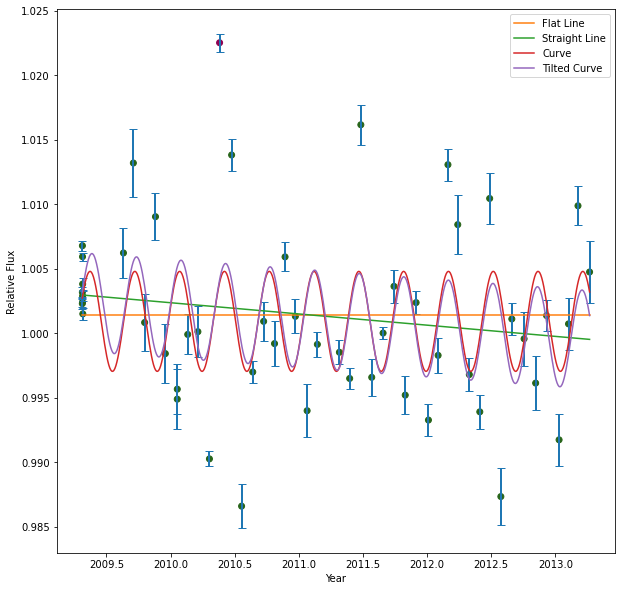

CP/CB: 0.0
EB: 0.0
Flat line L2 error: 2568.6782600683064
Straight line L2 error: 2297.9402192307134
Curve L2 error: 1894.143279620532
Tilted curve L2 error: 1848.500431569396
Standard deviation: 0.0070248370523785

-- KIC: 1569843 --


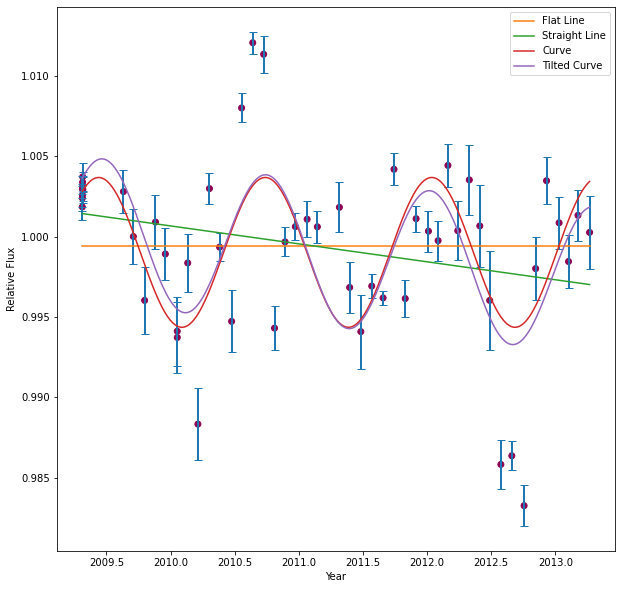

CP/CB: 0.0
EB: 0.0
Flat line L2 error: 1403.6604619467998
Straight line L2 error: 1140.5256969935754
Curve L2 error: 748.8486058352443
Tilted curve L2 error: 697.3283944206329
Standard deviation: 0.0054432045101515

-- KIC: 1569863 --


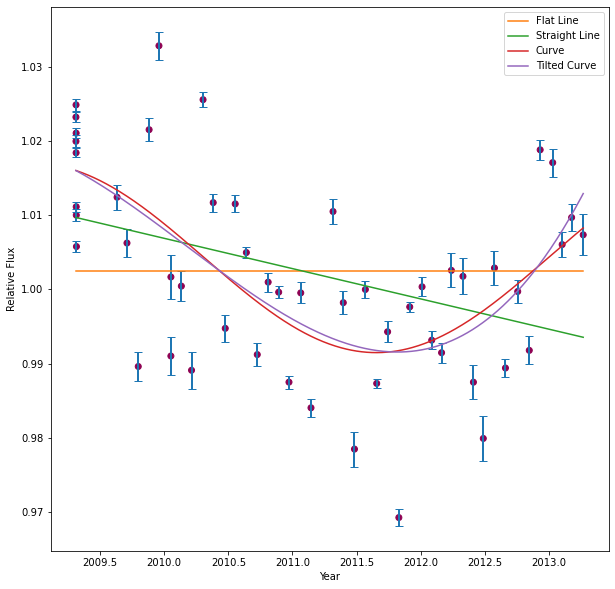

CP/CB: 0.0
EB: 0.0
Flat line L2 error: 8154.45205136712
Straight line L2 error: 5129.277709816361
Curve L2 error: 3068.9091966490787
Tilted curve L2 error: 3060.570706905181
Standard deviation: 0.0133305090985497

-- KIC: 1569897 --


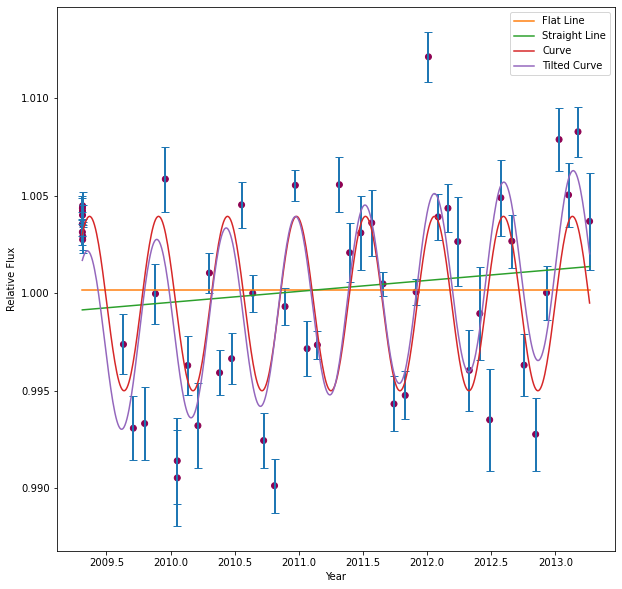

CP/CB: 0.0
EB: 0.0
Flat line L2 error: 827.7675257211857
Straight line L2 error: 952.4389689643432
Curve L2 error: 387.9468024138275
Tilted curve L2 error: 420.5001455690446
Standard deviation: 0.0050983758115346

-- KIC: 1569909 --


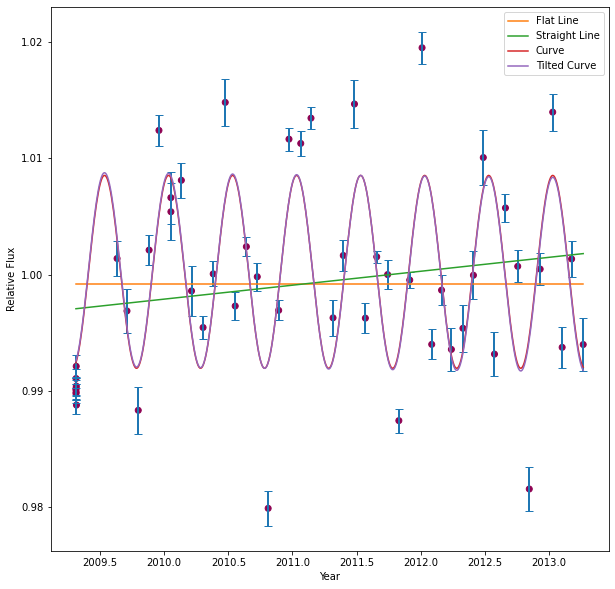

CP/CB: 0.0
EB: 0.0
Flat line L2 error: 2677.285655136513
Straight line L2 error: 2303.259006978248
Curve L2 error: 1107.8210816975068
Tilted curve L2 error: 1113.979935530153
Standard deviation: 0.0087290064078148

-- KIC: 1570150 --


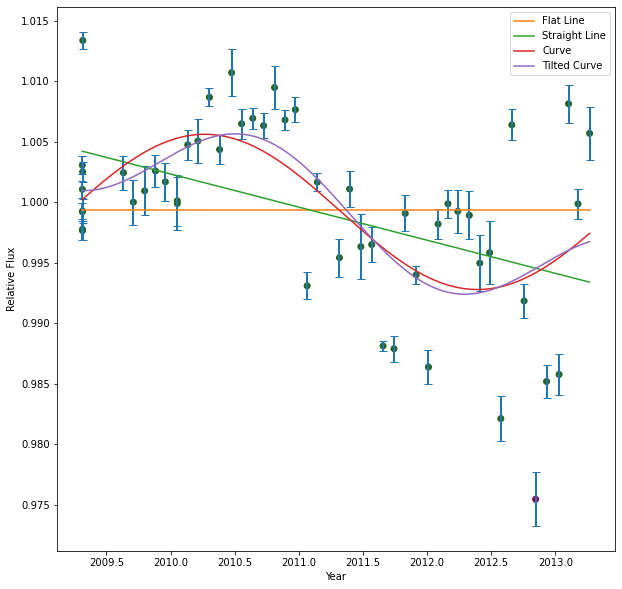

CP/CB: 0.0
EB: 0.0
Flat line L2 error: 2496.289258482841
Straight line L2 error: 1935.068849360949
Curve L2 error: 1457.754051985224
Tilted curve L2 error: 1401.904455604287
Standard deviation: 0.0075841932194546

-- KIC: 1570466 --


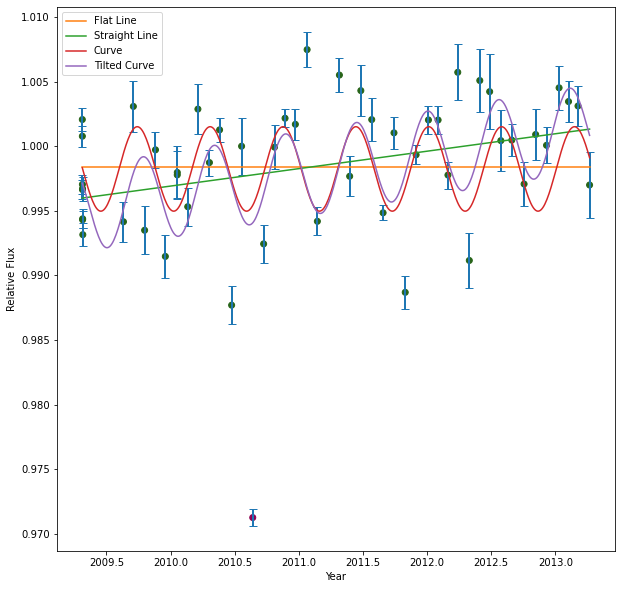

CP/CB: 0.0
EB: 0.0
Flat line L2 error: 2295.5752281571613
Straight line L2 error: 2172.726372744227
Curve L2 error: 1829.7667450452784
Tilted curve L2 error: 1628.9739424587103
Standard deviation: 0.005865982239834

-- KIC: 1570608 --


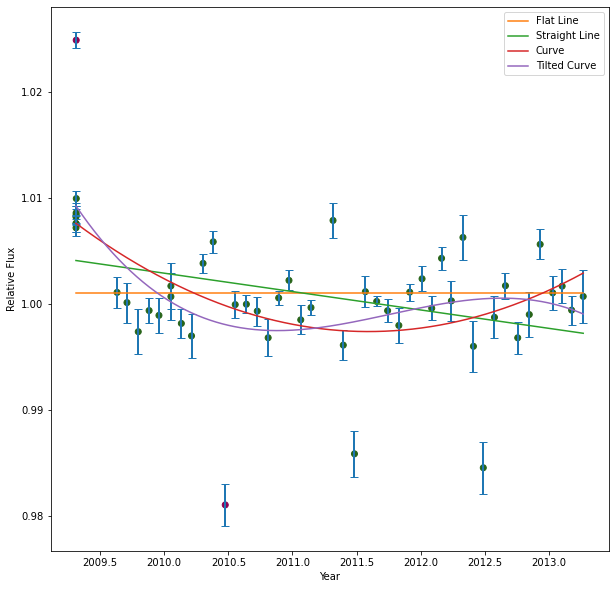

CP/CB: 0.0
EB: 0.0
Flat line L2 error: 1869.926208677356
Straight line L2 error: 1319.480579190663
Curve L2 error: 981.3795015055116
Tilted curve L2 error: 856.4180858040432
Standard deviation: 0.006426021586105

-- KIC: 1570703 --


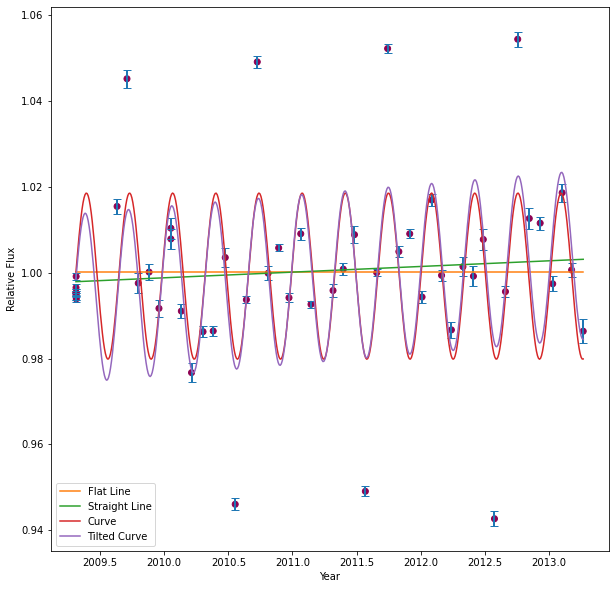

CP/CB: 0.0
EB: 0.0
Flat line L2 error: 11513.236579016431
Straight line L2 error: 11215.462597793488
Curve L2 error: 8226.923518859432
Tilted curve L2 error: 7837.871219816273
Standard deviation: 0.0207681583884342



In [6]:
# Visualize plots

i = 0
data = short_term()
# data = data[data['eb'] == 0]
print(len(data))
for kic in data['KIC']:
    # visualize(kic)
    if i > 110 and i < 120:
        visualize(kic)
    i += 1